# Insurance Price Prediction

**Introduction:**

This case study aims to predict insurance charges using multiple regression analysis. The dataset includes information about policyholders such as age, gender, BMI, number of children, smoking status, region, and insurance charges.

**Objective:**

The goal is to build a model that accurately estimates insurance costs based on individual characteristics. This can help insurance companies set fair premiums and assist customers in understanding factors affecting their insurance prices.

## Data Exploration

In [45]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

df = pd.read_csv('../data/insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [23]:
# Checking data types and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [24]:
# Check for missing values in each column
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

### Inspecting class distribution in categorical features

In [25]:
# Explore distribution of categorical variables
df.sex.value_counts()

sex
male      676
female    662
Name: count, dtype: int64

In [26]:
df.smoker.value_counts()

smoker
no     1064
yes     274
Name: count, dtype: int64

Major chunk are non smoker ( 70% ) so this distribution is imbalanced.

In [27]:
df.region.value_counts()

region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64

In [28]:
# Round BMI and charges for simplicity
df['bmi'] = df['bmi'].round()
df['charges'] = df['charges'].round()

## Data Preprocessing

### Encode Categorical Variables

In [29]:
### Encoding Categorical Variables
# For example: OneHotEncoder converts categories like "Male" and "Female" into separate binary columns (not just 0 and 1).

from sklearn.preprocessing import OneHotEncoder
# OneHotEncoder is for nominal data

# Columns with categorical data to encode
cat_columns = ['sex','smoker','region']


# Initialize OneHotEncoder; drop='first' avoids dummy variable trap by removing one category per feature
# drop='first' = skip one category to avoid redundant columns,
# sparse=False(optional) = get a normal array/dense array instead of a compressed one.
ohe = OneHotEncoder(drop = 'first', sparse_output=False, dtype=int)

# Fit encoder on data and transform categorical columns to one-hot encoded format
df_encoded = ohe.fit_transform(df[cat_columns])

# Note:
# - 'fit' learns the encoding from data,
# - 'transform' applies the encoding,
# - 'fit_transform' does both in one step and is commonly used in preprocessing.

In [30]:
df_encoded

array([[0, 1, 0, 0, 1],
       [1, 0, 0, 1, 0],
       [1, 0, 0, 1, 0],
       ...,
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1],
       [0, 1, 1, 0, 0]])

In [31]:
ohe.get_feature_names_out(cat_columns)

array(['sex_male', 'smoker_yes', 'region_northwest', 'region_southeast',
       'region_southwest'], dtype=object)

In [32]:
df_encoded = pd.DataFrame(df_encoded, columns = ohe.get_feature_names_out(cat_columns))
df_encoded

,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,0,1,0,0,1
1,1,0,0,1,0
2,1,0,0,1,0
3,1,0,1,0,0
4,1,0,1,0,0
...,...,...,...,...,...
1333,1,0,1,0,0
1334,0,0,0,0,0
1335,0,0,0,1,0
1336,0,0,0,0,1


In [33]:
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,28.0,0,yes,southwest,16885.0
1,18,male,34.0,1,no,southeast,1726.0
2,28,male,33.0,3,no,southeast,4449.0
3,33,male,23.0,0,no,northwest,21984.0
4,32,male,29.0,0,no,northwest,3867.0
...,...,...,...,...,...,...,...
1333,50,male,31.0,3,no,northwest,10601.0
1334,18,female,32.0,0,no,northeast,2206.0
1335,18,female,37.0,0,no,southeast,1630.0
1336,21,female,26.0,0,no,southwest,2008.0


In [34]:
df_encoded = pd.concat([df.drop(cat_columns, axis = 1), df_encoded], axis = 1)
df_encoded

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,28.0,0,16885.0,0,1,0,0,1
1,18,34.0,1,1726.0,1,0,0,1,0
2,28,33.0,3,4449.0,1,0,0,1,0
3,33,23.0,0,21984.0,1,0,1,0,0
4,32,29.0,0,3867.0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...
1333,50,31.0,3,10601.0,1,0,1,0,0
1334,18,32.0,0,2206.0,0,0,0,0,0
1335,18,37.0,0,1630.0,0,0,0,1,0
1336,21,26.0,0,2008.0,0,0,0,0,1


### Check Numerical Distributions

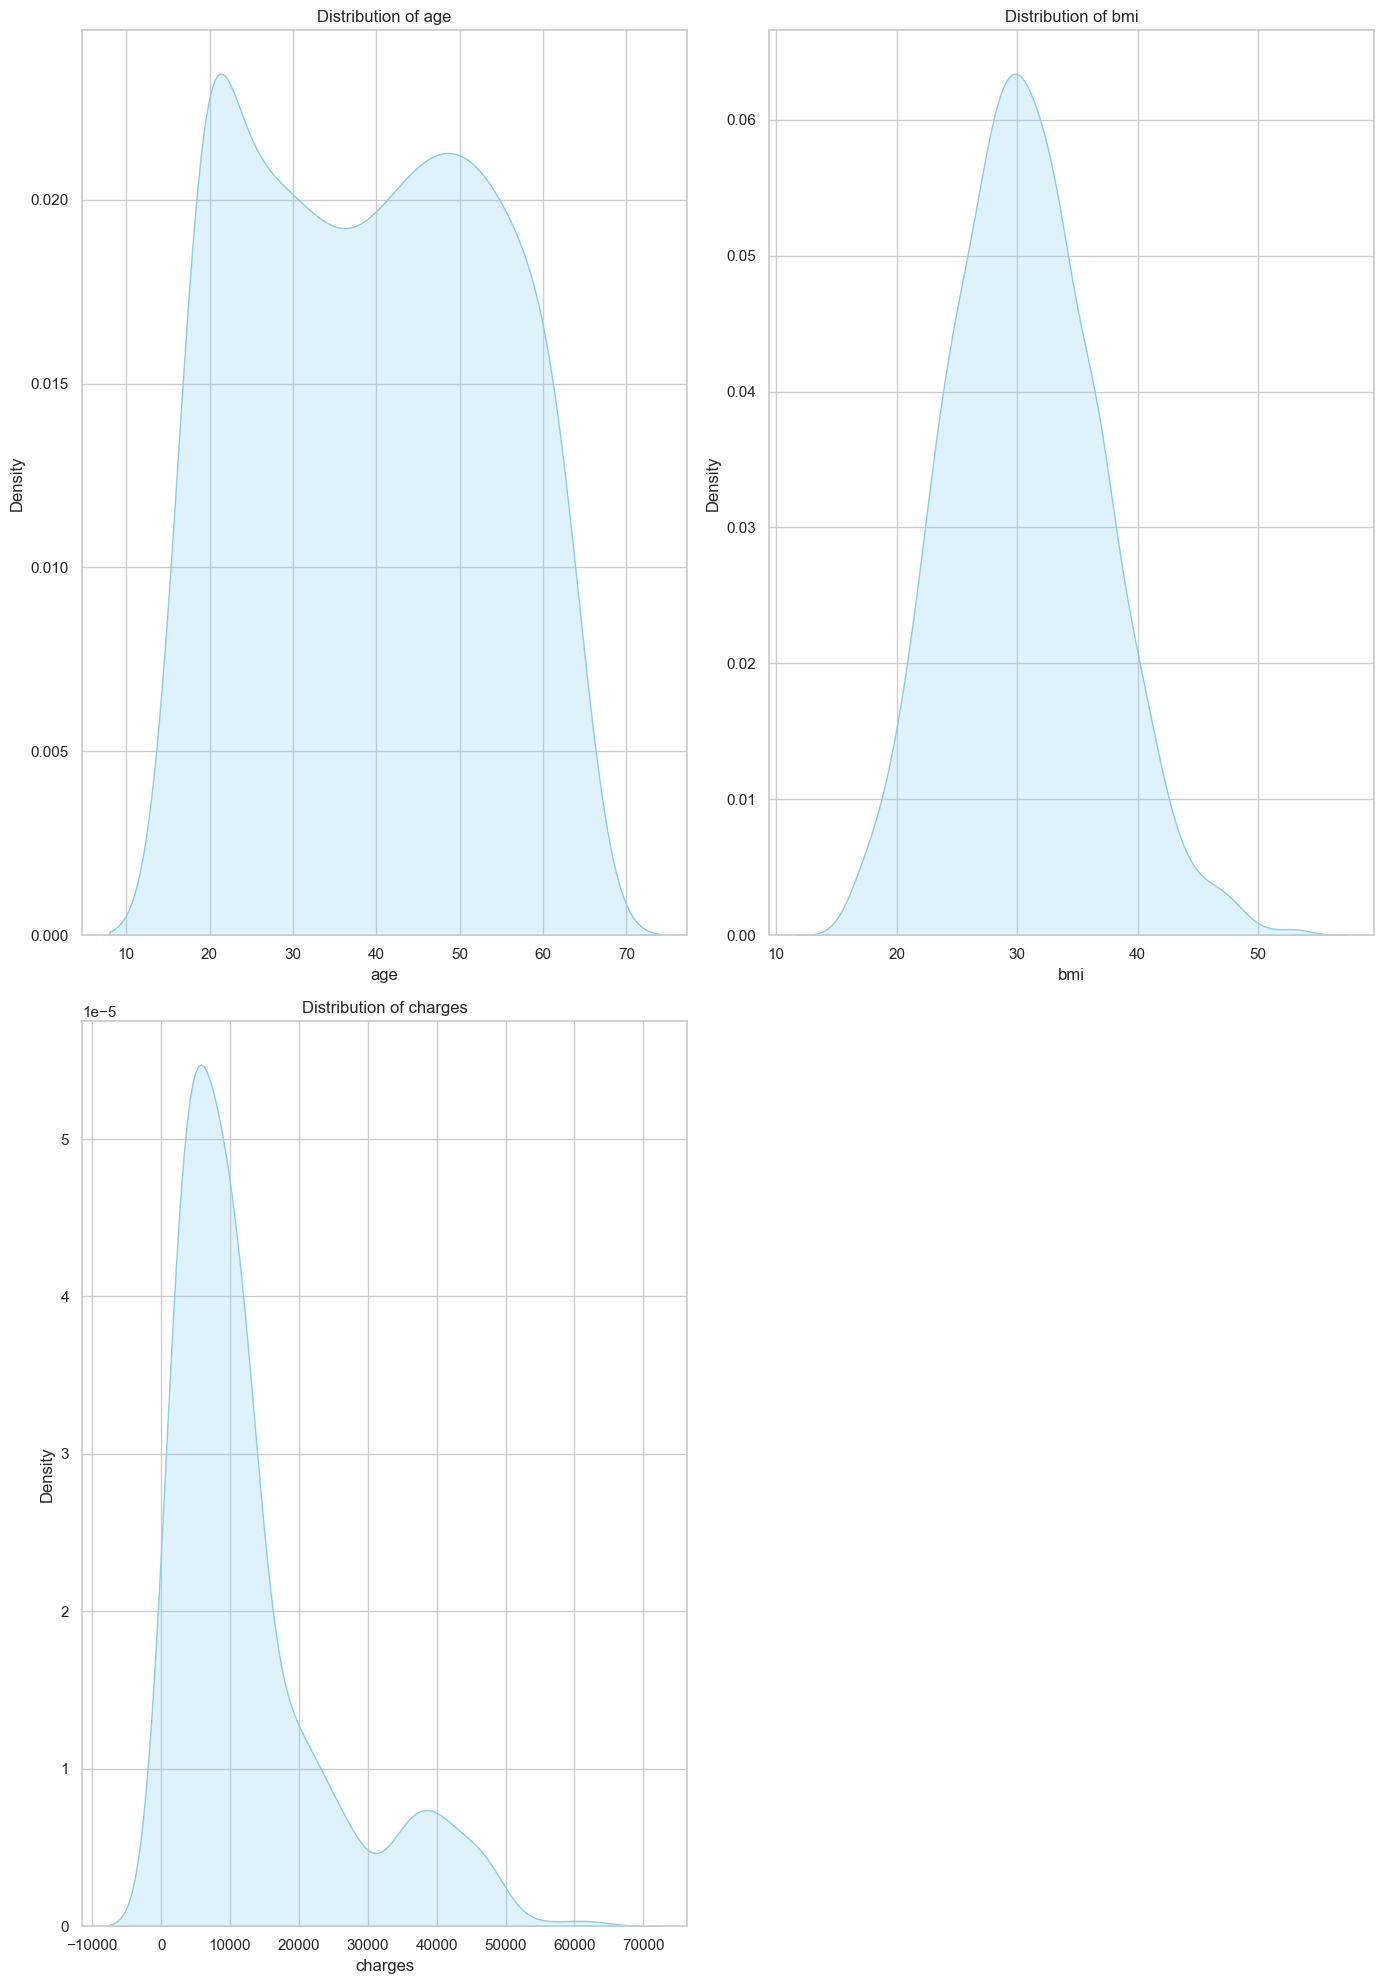

In [35]:
import seaborn as sns

numerical_cols = ['age','bmi','charges']

# Apply a clean white grid style to all plots
sns.set(style="whitegrid")

# Create a figure canvas with enough space for multiple subplots
plt.figure(figsize=(14,20))

#Loop through and plot the distribution (KDE) for each numerical column
for i,col in enumerate(numerical_cols,1):
    plt.subplot(2,2,i) # Create subplot (2 rows × 2 columns layout)
    sns.kdeplot(df_encoded[col], fill = True, color = 'skyblue') # Smooth density curve
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel('Density')

plt.tight_layout()
plt.show()


When deciding which scaling method to use:

- Normalization is better if your data is not normally (Gaussian) distributed. It keeps the shape of the distribution the same but is sensitive to outliers.

- Standardization works well if your data is normally distributed. It adjusts the distribution to have mean 0 and standard deviation 1, and is generally less affected by outliers.

- Normalization (often Min–Max scaling) rescales values to a fixed range (like 0 to 1).
  - It does not require Gaussian distribution.

  - It’s sensitive to outliers because an extreme value can squash the rest of the data into a tiny range.

  - It does keep the original data’s shape — no mean/variance adjustment.

- Standardization (z-score scaling) transforms data so the mean is 0 and standard deviation is 1.

  - It does not require data to be perfectly Gaussian — but it works best if the distribution is roughly bell-shaped.

  - It’s less sensitive to outliers than min–max scaling, but still affected if outliers are extreme.

  - It changes the scale and often the shape (especially if data isn’t Gaussian).

## Train-Test Split

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Split dataset into features (X) and target variable (y)
# 'charges' is the target, all other columns are features
# Use 80% of data for training and 20% for testing
# random_state ensures reproducibility of the split
X_train, X_test, y_train, y_test = train_test_split(
    df_encoded.drop('charges', axis=1),  # Features
    df_encoded['charges'],               # Target variable
    test_size=0.2,
    random_state=42
)

# Output the shape of training and testing feature sets
X_train.shape,X_test.shape

((1070, 8), (268, 8))

In [41]:
X_train

,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
560,46,20.0,2,0,0,1,0,0
1285,47,24.0,0,0,0,0,0,0
1142,52,25.0,0,0,0,0,1,0
969,39,34.0,5,0,0,0,1,0
486,54,21.0,3,0,0,1,0,0
...,...,...,...,...,...,...,...,...
1095,18,31.0,4,0,0,0,0,0
1130,39,24.0,5,0,0,0,1,0
1294,58,25.0,0,1,0,0,0,0
860,37,48.0,2,0,1,0,0,1


## Feature Scaling

### Apply Standardization

In [37]:
# Standardize features so that each feature has mean = 0 and standard deviation = 1.
 
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler object to normalize features
# This will ensure each feature has mean = 0 and standard deviation = 1
scaler = StandardScaler()

# Fit the scaler on training data (calculate mean & std) 
# and scale the training set using those values
X_train_scaled = scaler.fit_transform(X_train)

# Scale the test set using the same mean & std from the training set 
# (important to prevent data leakage)
X_test_scaled = scaler.transform(X_test)


In [38]:
X_train_scaled

array([[ 0.47222651, -1.74848249,  0.73433626, ...,  1.78316783,
        -0.59966106, -0.5723141 ],
       [ 0.54331294, -1.08593224, -0.91119211, ..., -0.56079971,
        -0.59966106, -0.5723141 ],
       [ 0.8987451 , -0.92029468, -0.91119211, ..., -0.56079971,
         1.66760869, -0.5723141 ],
       ...,
       [ 1.3252637 , -0.92029468, -0.91119211, ..., -0.56079971,
        -0.59966106, -0.5723141 ],
       [-0.16755139,  2.88936926,  0.73433626, ..., -0.56079971,
        -0.59966106,  1.74729228],
       [ 1.1120044 , -0.09210687, -0.91119211, ..., -0.56079971,
        -0.59966106,  1.74729228]])

In [42]:
X_train_scaled = pd.DataFrame(X_train_scaled,columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled,columns=X_test.columns)

In [43]:
X_train_scaled

,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,0.472227,-1.748482,0.734336,-1.024602,-0.508747,1.783168,-0.599661,-0.572314
1,0.543313,-1.085932,-0.911192,-1.024602,-0.508747,-0.560800,-0.599661,-0.572314
2,0.898745,-0.920295,-0.911192,-1.024602,-0.508747,-0.560800,1.667609,-0.572314
3,-0.025379,0.570443,3.202629,-1.024602,-0.508747,-0.560800,1.667609,-0.572314
4,1.040918,-1.582845,1.557100,-1.024602,-0.508747,1.783168,-0.599661,-0.572314
...,...,...,...,...,...,...,...,...
1065,-1.518194,0.073531,2.379865,-1.024602,-0.508747,-0.560800,-0.599661,-0.572314
1066,-0.025379,-1.085932,3.202629,-1.024602,-0.508747,-0.560800,1.667609,-0.572314
1067,1.325264,-0.920295,-0.911192,0.975989,-0.508747,-0.560800,-0.599661,-0.572314
1068,-0.167551,2.889369,0.734336,-1.024602,1.965613,-0.560800,-0.599661,1.747292


### Visual Check of Scaling Effect
Before & after scatter plots to confirm scale changes

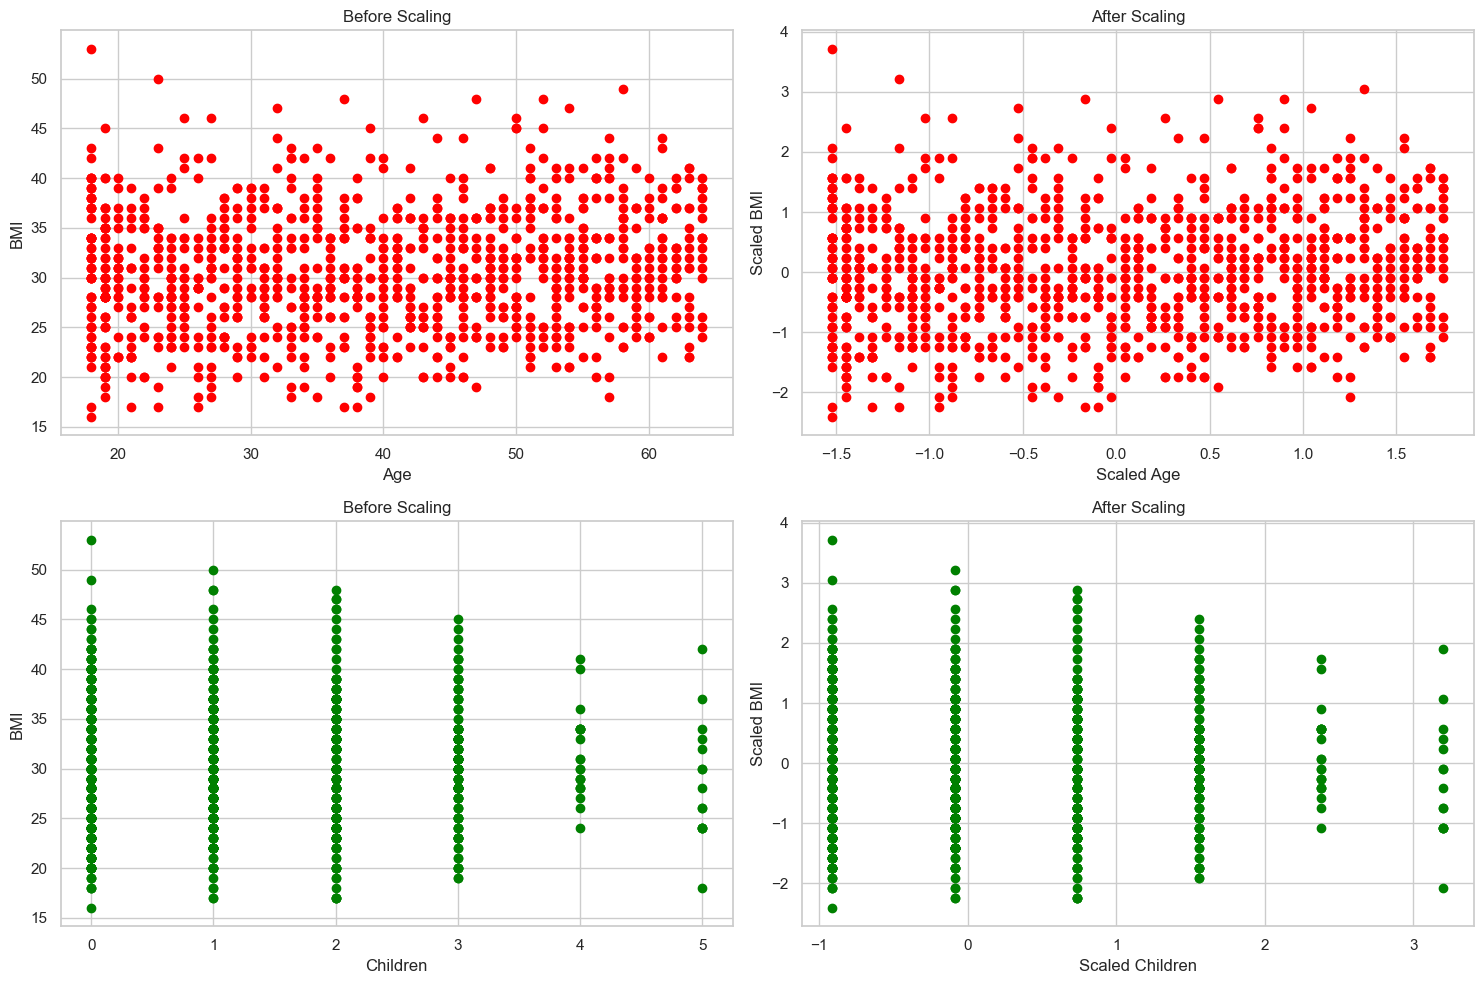

In [44]:
fig,axes = plt.subplots(nrows=2,ncols=2,figsize=(15,10))

# Scatter plot for 'age' and 'bmi' before scaling
axes[0,0].scatter(X_train['age'], X_train['bmi'], color = 'red')
axes[0,0].set_title('Before Scaling')
axes[0,0].set_xlabel('Age')
axes[0,0].set_ylabel('BMI')

# Scatter plot for 'age' and 'bmi' after scaling
axes[0,1].scatter(X_train_scaled['age'], X_train_scaled['bmi'], color = 'red')
axes[0,1].set_title('After Scaling')
axes[0,1].set_xlabel('Scaled Age')
axes[0,1].set_ylabel('Scaled BMI')

# Scatter plot for 'children' and 'bmi' before scaling
axes[1,0].scatter(X_train['children'], X_train['bmi'], color = 'green')
axes[1,0].set_title('Before Scaling')
axes[1,0].set_xlabel('Children')
axes[1,0].set_ylabel('BMI')

# Scatter plot for 'children' and 'bmi' after scaling
axes[1,1].scatter(X_train_scaled['children'], X_train_scaled['bmi'], color = 'green')
axes[1,1].set_title('After Scaling')
axes[1,1].set_xlabel('Scaled Children')
axes[1,1].set_ylabel('Scaled BMI')

plt.tight_layout()
plt.show()



Even after scaling , its not changing the meaning.